# Willman 1: Particle spray stream

Import necessary packages

In [1]:
import pandas as pd
import numpy as np

from astropy import units as u
import astropy.coordinates as coord
from astropy.coordinates import SkyCoord
from galpy.orbit import Orbit
import astropy.coordinates as coord

import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse

import gala.potential as gp
import gala.dynamics as gd
from gala.dynamics import mockstream as ms
from gala.units import galactic
from gala.units import UnitSystem
from gala.coordinates import reflex_correct
from gala.potential.potential.interop import galpy_to_gala_potential

from scipy.stats import gaussian_kde
from wil1_properties import aax, bax, ra_w1, dec_w1, dist, pmra_w1, pmdec_w1, vsys, mass_w1, r_half_pc

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
A new version of galpy (1.11.1) is available, please upgrade using pip/conda/... to get the latest features and bug fixes!


In [2]:
# some code for prettier plots
%config InlineBackend.figure_format = 'retina'
plt.rcParams.update({'axes.linewidth' : 1,
                     'ytick.major.width' : 1,
                     'ytick.minor.width' : 1,
                     'xtick.major.width' : 1,
                     'xtick.minor.width' : 1,
                     'xtick.labelsize': 12, 
                     'ytick.labelsize': 12,
                     'axes.labelsize': 16,
                     'font.family': 'Serif',
                     'figure.figsize': (10, 6),
                     'xtick.direction': 'in',
                     'ytick.direction': 'in',
                     'xtick.major.size': 8,
                     'ytick.major.size': 8,
                     'xtick.minor.size': 4,
                     'ytick.minor.size': 4})

Member sample

In [3]:
deimos_data = pd.read_csv("data/dmost_alldata_evaluated.csv")

gaia_deimos    = deimos_data[(deimos_data["gaia_pmra_err"] > 0) & (deimos_data["pm_err_flag"] == 0)]
gaia_mems      = deimos_data[(deimos_data["sample"] == 1) & (deimos_data["gaia_pmra_err"] > 0) & (deimos_data["pm_err_flag"] == 0)]
w1_members     = deimos_data[(deimos_data["sample"] == 1)]

len(gaia_deimos), len(gaia_mems), len(w1_members)

(65, 7, 57)

### Orbit of W1

In [4]:
# define phase-space position of Wil1
wil1_c = coord.SkyCoord(ra = ra_w1 * u.degree, dec = dec_w1 * u.degree, distance = dist * u.kpc,
                        pm_ra_cosdec = pmra_w1[0] * u.mas/u.yr, pm_dec = pmdec_w1[0] * u.mas/u.yr, 
                        radial_velocity = (vsys[0]) * u.km/u.s)

# convert to cartesian galactocentric coordinates
wil1_cartesian = wil1_c.transform_to(coord.Galactocentric)

# phase space position
w0 = gd.PhaseSpacePosition(pos=[wil1_cartesian.x.value, wil1_cartesian.y.value, wil1_cartesian.z.value] * u.kpc, 
                           vel=[wil1_cartesian.v_x.value, wil1_cartesian.v_y.value, wil1_cartesian.v_z.value] * u.km / u.s)

In [5]:
# define MW gravitational potentials
pot1 = gp.BovyMWPotential2014(units = UnitSystem(u.kpc, u.Myr, u.solMass, u.rad)) #regular MWPotential2014

m = gp.BovyMWPotential2014(units = UnitSystem(u.kpc, u.Myr, u.solMass, u.rad))['halo'].parameters['m'] * 1.5 #increase halo mass by 1.5
pot2 = gp.BovyMWPotential2014(halo = dict(m = m))

pot3 = gp.MilkyWayPotential()

# integrate orbit
orbit1 = gp.Hamiltonian(pot1).integrate_orbit(w0, dt=-1., n_steps=1000)
orbit2 = gp.Hamiltonian(pot2).integrate_orbit(w0, dt=-1., n_steps=1000)
orbit3 = gp.Hamiltonian(pot3).integrate_orbit(w0, dt=-1., n_steps=1000)
t_step = np.linspace(0, -1., 1001) * u.Gyr

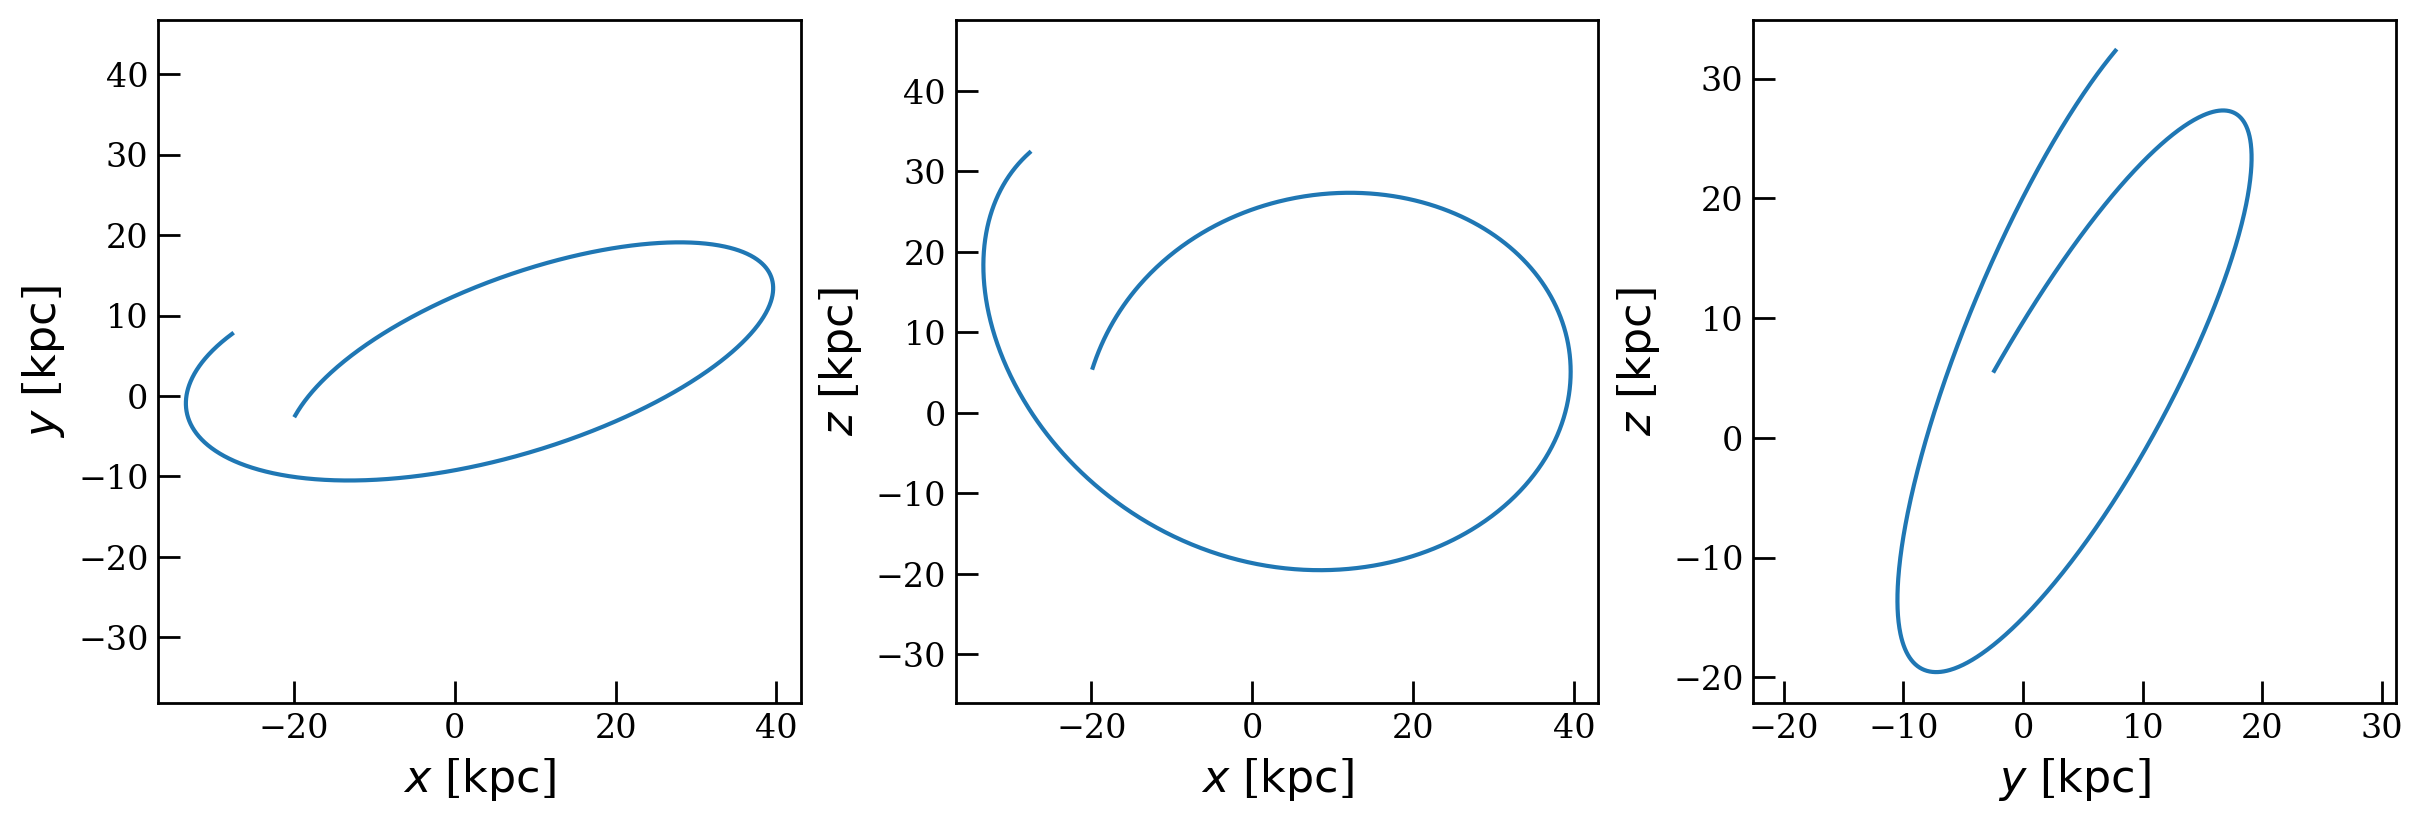

In [6]:
fig = orbit2.plot()

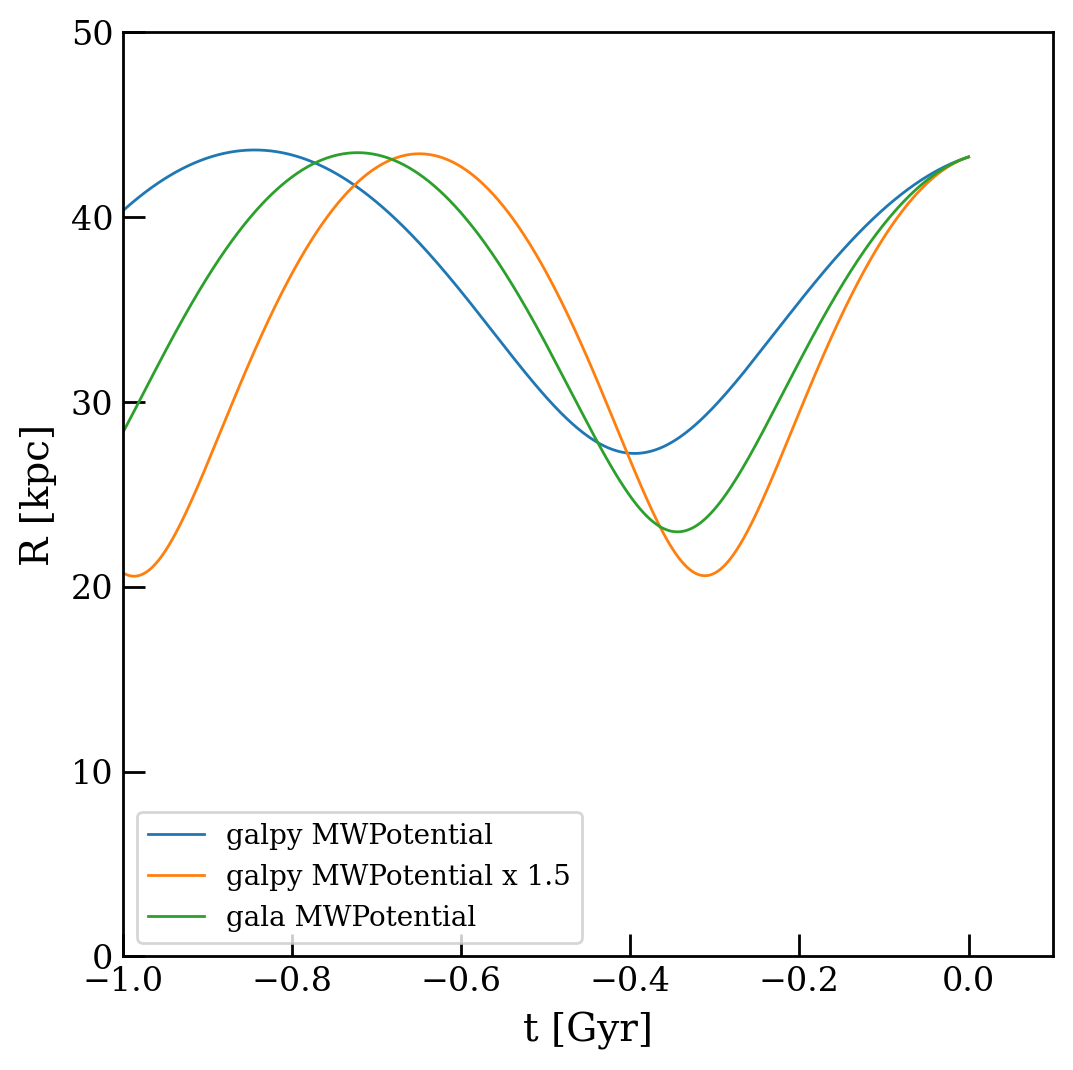

In [7]:
orbit_r1 = (orbit1.x ** 2 + orbit1.y ** 2 + orbit1.z ** 2) ** (1/2)
orbit_r2 = (orbit2.x ** 2 + orbit2.y ** 2 + orbit2.z ** 2) ** (1/2)
orbit_r3 = (orbit3.x ** 2 + orbit3.y ** 2 + orbit3.z ** 2) ** (1/2)

# radius vs time figure
plt.figure(figsize = (6, 6))

plt.plot(t_step, orbit_r1, linewidth = 1, label = "galpy MWPotential")
plt.plot(t_step, orbit_r2, linewidth = 1, label = "galpy MWPotential x 1.5")
plt.plot(t_step, orbit_r3, linewidth = 1, label = "gala MWPotential")

plt.xlabel("t [Gyr]", labelpad = 5, size = 14)
plt.ylabel("R [kpc]", labelpad = 5, size = 14)

plt.xlim(-1, 0.1)
plt.ylim(0, 50)

plt.legend(loc = "lower left", fontsize = 10)

### Particle spray model

In [8]:
# static reference frame (represents a composition of a gravitational potential and a reference frame.)
H1 = gp.Hamiltonian(pot1)
H2 = gp.Hamiltonian(pot2)
H3 = gp.Hamiltonian(pot3)

# generate fardal stream distribution function specify the progenitor mass (used to scale the particle release distribution)
df = ms.FardalStreamDF()

# create gravitational potential for Wil1
wil1_mass = mass_w1[0] * u.Msun
wil1_pot = gp.PlummerPotential(m = wil1_mass, b = r_half_pc * u.pc, units=galactic)

# generate a mock stellar stream in the specified external potential
gen_wil1_1 = ms.MockStreamGenerator(df, H1, progenitor_potential = wil1_pot) #add in wil1 potential
gen_wil1_2 = ms.MockStreamGenerator(df, H2, progenitor_potential = wil1_pot)
gen_wil1_3 = ms.MockStreamGenerator(df, H3, progenitor_potential = wil1_pot)

# run the generator and create a mock stream (integrate the progenitor orbit for 1000 steps with a timestep of 1 Myr)
wil1_stream1, prog1 = gen_wil1_1.run(w0, wil1_mass, dt=-1., n_steps=1000, n_particles = 6)
wil1_stream_c1 = wil1_stream1.to_coord_frame(coord.ICRS)

wil1_stream2, prog2 = gen_wil1_2.run(w0, wil1_mass, dt=-1., n_steps=1000, n_particles = 6)
wil1_stream_c2 = wil1_stream2.to_coord_frame(coord.ICRS)

wil1_stream3, prog3 = gen_wil1_3.run(w0, wil1_mass, dt=-1., n_steps=1000, n_particles = 6)
wil1_stream_c3 = wil1_stream3.to_coord_frame(coord.ICRS)

/Users/camillechiu/opt/anaconda3/envs/astrowillman1/lib/python3.12/site-packages/astropy/coordinates/baseframe.py:1280: AstropyDeprecationWarning: Transforming a frame instance to a frame class (as opposed to another frame instance) will not be supported in the future.  Either explicitly instantiate the target frame, or first convert the source frame instance to a `astropy.coordinates.SkyCoord` and use its `transform_to()` method.
  warnings.warn(



In [9]:
# kernel density estimate (KDE) on stream data
xy = np.vstack([(wil1_stream_c2.ra.degree - ra_w1) * np.cos(np.deg2rad(dec_w1)), wil1_stream_c2.dec.degree - dec_w1])
kde = gaussian_kde(xy)

# evaluate KDE on grid
xgrid = np.linspace(-1.5, 1.5, 100)
ygrid = np.linspace(-1.5, 1.5, 100)
X, Y = np.meshgrid(xgrid, ygrid)
Z = kde(np.vstack([X.ravel(), Y.ravel()])).reshape(X.shape)

Proper motion analysis

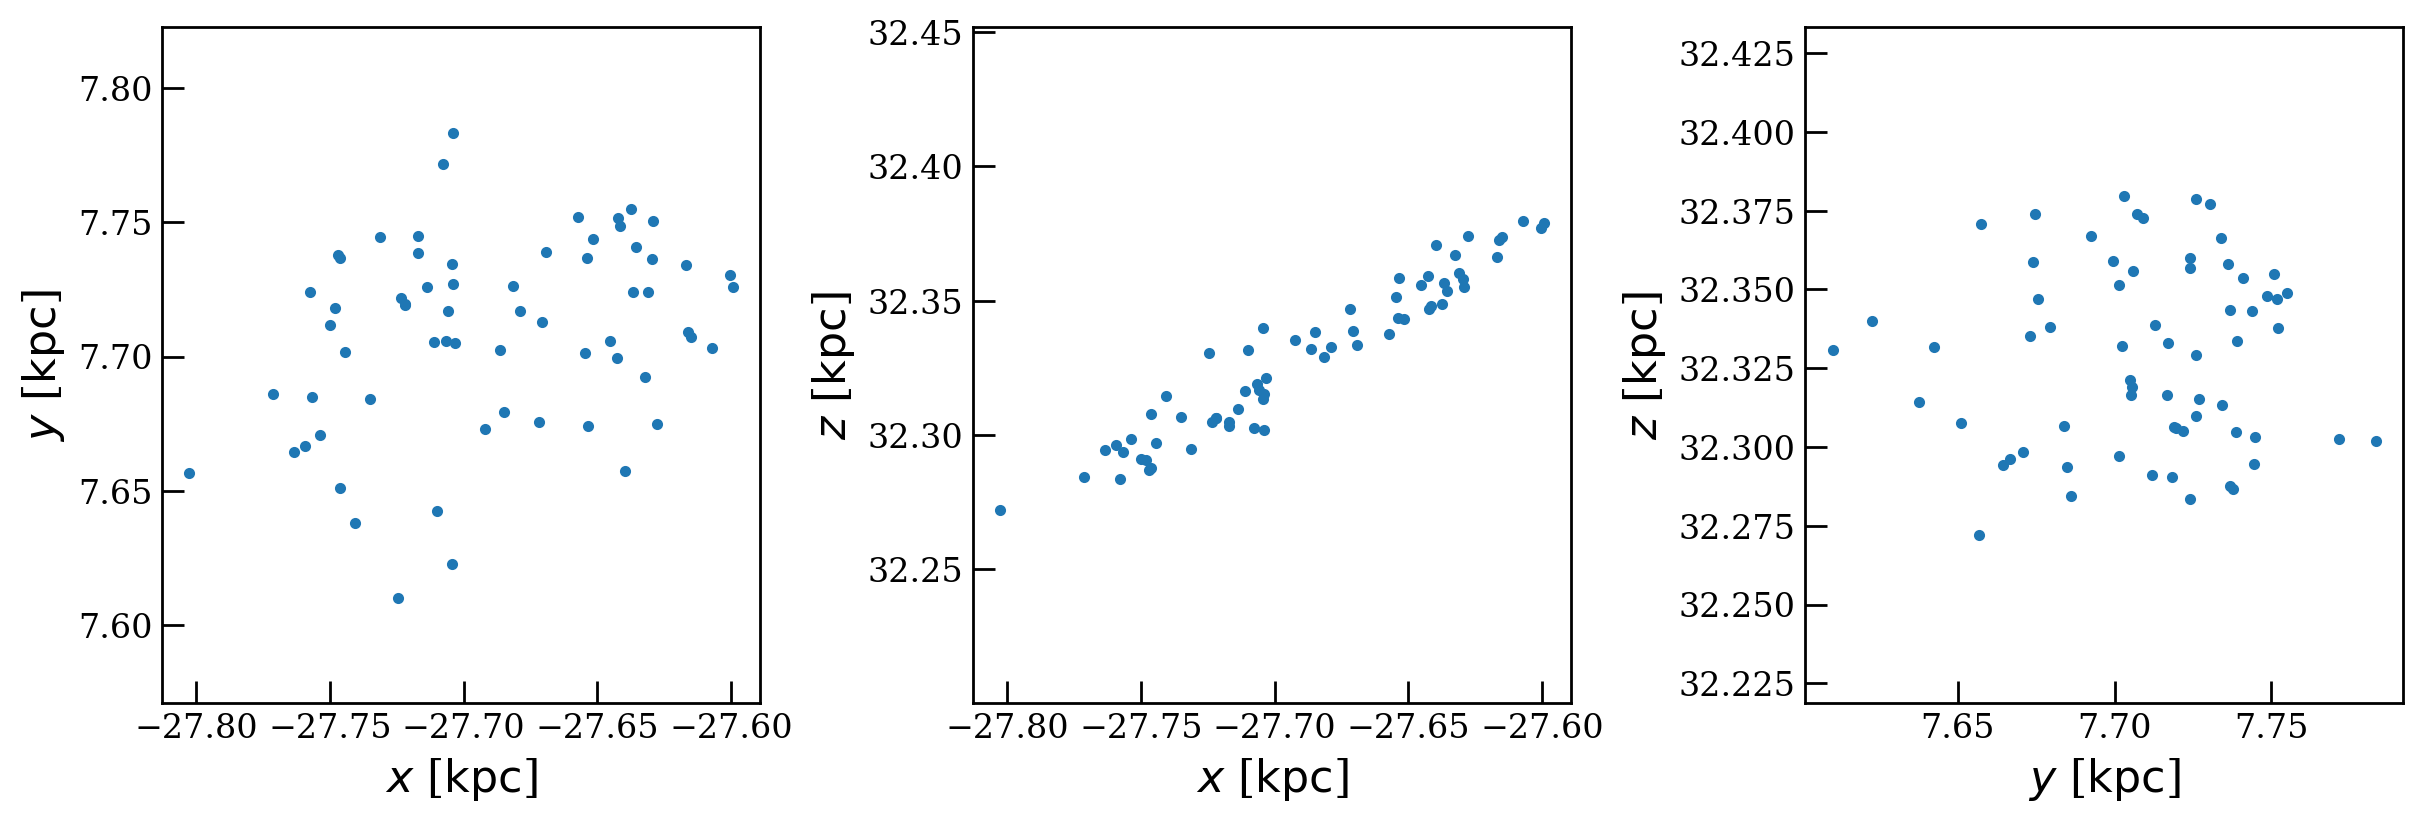

In [10]:
# all deimos/gaia data
deimos_c = coord.SkyCoord(ra = gaia_deimos["RA"].values * u.degree, dec = gaia_deimos["DEC"].values * u.degree, 
                           distance = np.full((len(gaia_deimos)), dist) * u.kpc,
                           pm_ra_cosdec = gaia_deimos["gaia_pmra"].values * u.mas/u.yr, pm_dec = gaia_deimos["gaia_pmdec"].values * u.mas/u.yr, 
                           radial_velocity = gaia_deimos["v"].values * u.km/u.s)
deimos_cart = deimos_c.transform_to(coord.Galactocentric)

deimos0 = gd.PhaseSpacePosition(pos=[deimos_cart.x.value, deimos_cart.y.value, deimos_cart.z.value] * u.kpc, 
                                 vel=[deimos_cart.v_x.value, deimos_cart.v_y.value, deimos_cart.v_z.value] * u.km / u.s)

fig1 = deimos0.plot()

pm_vec_deimos = reflex_correct(deimos_c)
pmra_deimos   = pm_vec_deimos.pm_ra_cosdec.value
pmdec_deimos  = pm_vec_deimos.pm_dec.value

U_deimos = pmra_deimos / np.sqrt(pmra_deimos**2 + pmdec_deimos**2)
V_deimos = pmdec_deimos / np.sqrt(pmra_deimos**2 + pmdec_deimos**2)

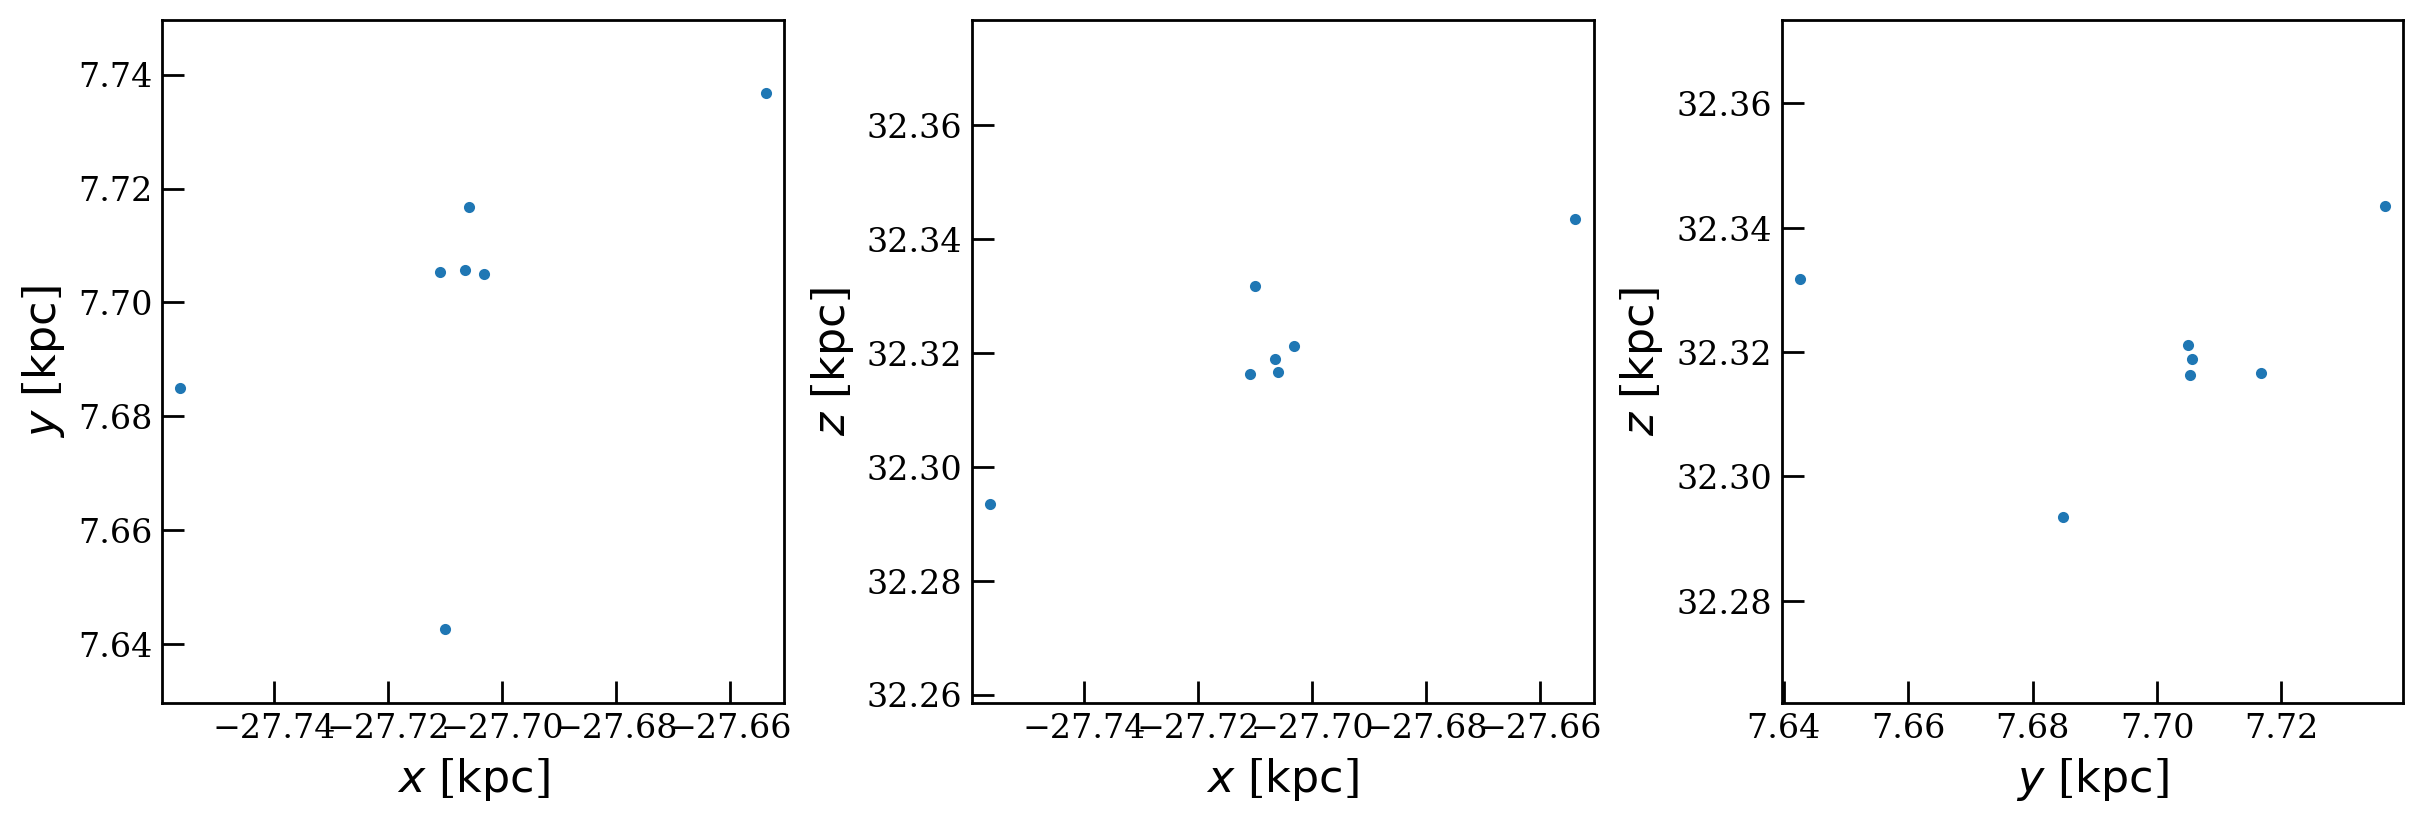

In [11]:
# phase space position of 6 gaia stars in W1
members_c = coord.SkyCoord(ra = gaia_mems["RA"].values * u.degree, dec = gaia_mems["DEC"].values * u.degree, 
                           distance = np.full((len(gaia_mems)), dist) * u.kpc,
                           pm_ra_cosdec = gaia_mems["gaia_pmra"].values * u.mas/u.yr, pm_dec = gaia_mems["gaia_pmdec"].values * u.mas/u.yr, 
                           radial_velocity = gaia_mems["v"].values * u.km/u.s)

members_cart = members_c.transform_to(coord.Galactocentric)

members0 = gd.PhaseSpacePosition(pos=[members_cart.x.value, members_cart.y.value, members_cart.z.value] * u.kpc, 
                                 vel=[members_cart.v_x.value, members_cart.v_y.value, members_cart.v_z.value] * u.km / u.s)

fig2 = members0.plot()

# calculate solar-reflex-corrected proper motion values
pm_vec_mems = reflex_correct(members_c)
pmra_mems   = pm_vec_mems.pm_ra_cosdec.value
pmdec_mems  = pm_vec_mems.pm_dec.value

# normalize values
U = pmra_mems / np.sqrt(pmra_mems**2 + pmdec_mems**2)
V = pmra_mems / np.sqrt(pmra_mems**2 + pmdec_mems**2)

In [12]:
# proper motion vector corrected for solar reflex motion
pm_vec = reflex_correct(wil1_c)

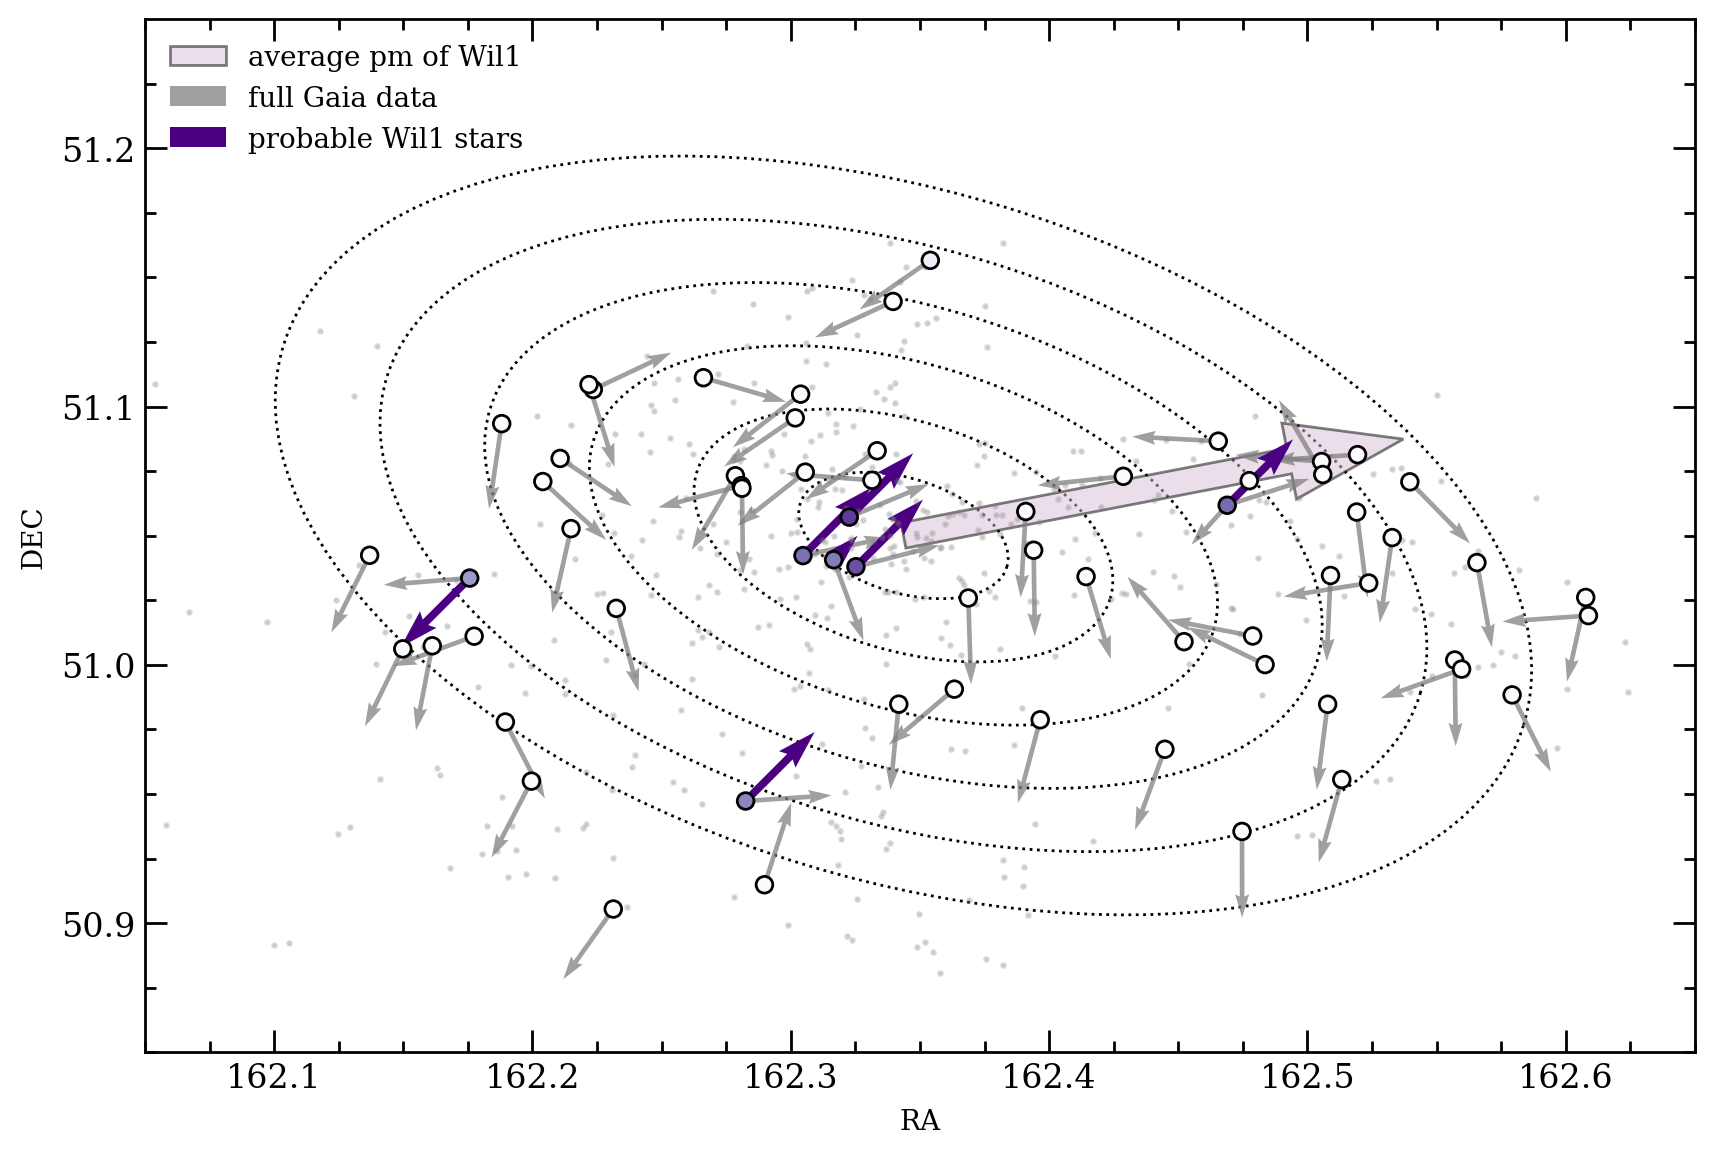

In [13]:
fig = plt.figure(figsize = (10, 8))
ax = fig.gca()
ax.set_aspect('equal', adjustable='box')

# half-light radii
for ii in range(6):
    jj = 2 * (ii + 1)
    ellipse = Ellipse((ra_w1, dec_w1), bax * jj, aax * jj, angle = 73, fill = False, linestyle = ":", edgecolor = "black")
    ax.add_patch(ellipse)

# pm vectors
plt.arrow(ra_w1, dec_w1, pm_vec.pm_ra_cosdec.value / 5, pm_vec.pm_dec.value / 5, 
          width = 0.01, alpha = 0.5, facecolor = "thistle", edgecolor = "black", label = "average pm of Wil1")
ax.quiver(gaia_deimos["RA"], gaia_deimos["DEC"], U_deimos, V_deimos, width = 0.003, facecolor = "grey", 
          alpha = 0.75, edgecolor = "black", label = "full Gaia data")
ax.quiver(gaia_mems["RA"], gaia_mems["DEC"], U, V, facecolor = "indigo", edgecolor = "black", width = 0.005, label = "probable Wil1 stars")

# data
ax.scatter(deimos_data["RA"], deimos_data["DEC"], alpha = 0.25, c = "grey", s = 2)
data = ax.scatter(gaia_deimos["RA"], gaia_deimos["DEC"], c = gaia_deimos["prob_member"], 
                  edgecolors = "black", cmap = "Purples", vmin = 0, vmax = 1)

ax.set_xlabel("RA", labelpad = 5, size = 10).set_color('black')
ax.set_ylabel("DEC", labelpad = 5, size = 10).set_color('black')

ax.set_xticks(np.arange(162, 162.8, .1), minor = False)
ax.set_xticks(np.arange(162, 162.8, 0.025), minor = True)
ax.tick_params(which = "major", axis = "x", direction = "in", size = 8, color = "black", top = True)
ax.tick_params(which = "minor", axis = "x", direction = "in", size = 4, color = "black", top = True)

ax.set_yticks(np.arange(50.8, 51.2, 0.1), minor = False)
ax.set_yticks(np.arange(50.85, 51.25, 0.025), minor = True)
ax.tick_params(which = "major", axis = "y", direction = "in", size = 8, color = "black", right = True)
ax.tick_params(which = "minor", axis = "y", direction = "in", size = 4, color = "black", right = True)

ax.set_xlim(162.05, 162.65)
ax.set_ylim(50.85, 51.25)

ax.legend(loc = 'upper left', fontsize = 10, frameon = False)

# fig.savefig("deimos_pm_vectors.pdf", dpi = 600, transparent = True)

In [14]:
# get ra/dec of orbit
orbit2 = gp.Hamiltonian(pot2).integrate_orbit(w0, dt=-.01, n_steps=1000)

c_orbit = SkyCoord(x = orbit2.x, y = orbit2.y, z = orbit2.z, 
                   v_x = orbit2.v_x, v_y = orbit2.v_y, v_z = orbit2.v_z, frame = "galactocentric")
c = c_orbit.transform_to(coord.Galactocentric)
orbit_ra = (c.icrs.ra.deg - ra_w1) * np.cos(np.deg2rad(dec_w1))
orbit_dec = c.icrs.dec.deg - dec_w1

# FIGURE 10: Particle Spray Stream

In [15]:
# alter color bar
import matplotlib 
min_val, max_val = 0.3, 1
n = 10

# purple
orig_cmap_purp = plt.cm.get_cmap('Purples')
colors_purp = orig_cmap_purp(np.linspace(min_val, max_val, n))
new_cmap = matplotlib.colors.LinearSegmentedColormap.from_list("mycmap", colors_purp)

/var/folders/3k/btgj6dcd6rgc2_bxvvn6172h0000gn/T/ipykernel_33622/1606564227.py:7: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  orig_cmap_purp = plt.cm.get_cmap('Purples')



In [16]:
import matplotlib 
thresh = 0.5
nodes = [0, thresh, thresh, 1.0]

# purple
orig_cmap_purp = plt.colormaps["Purples"]
colors_purp = ["#B3B6B7", "#B3B6B7", orig_cmap_purp(0.5), orig_cmap_purp(0.99)]
new_purple_cmap = matplotlib.colors.LinearSegmentedColormap.from_list("", list(zip(nodes, colors_purp)))

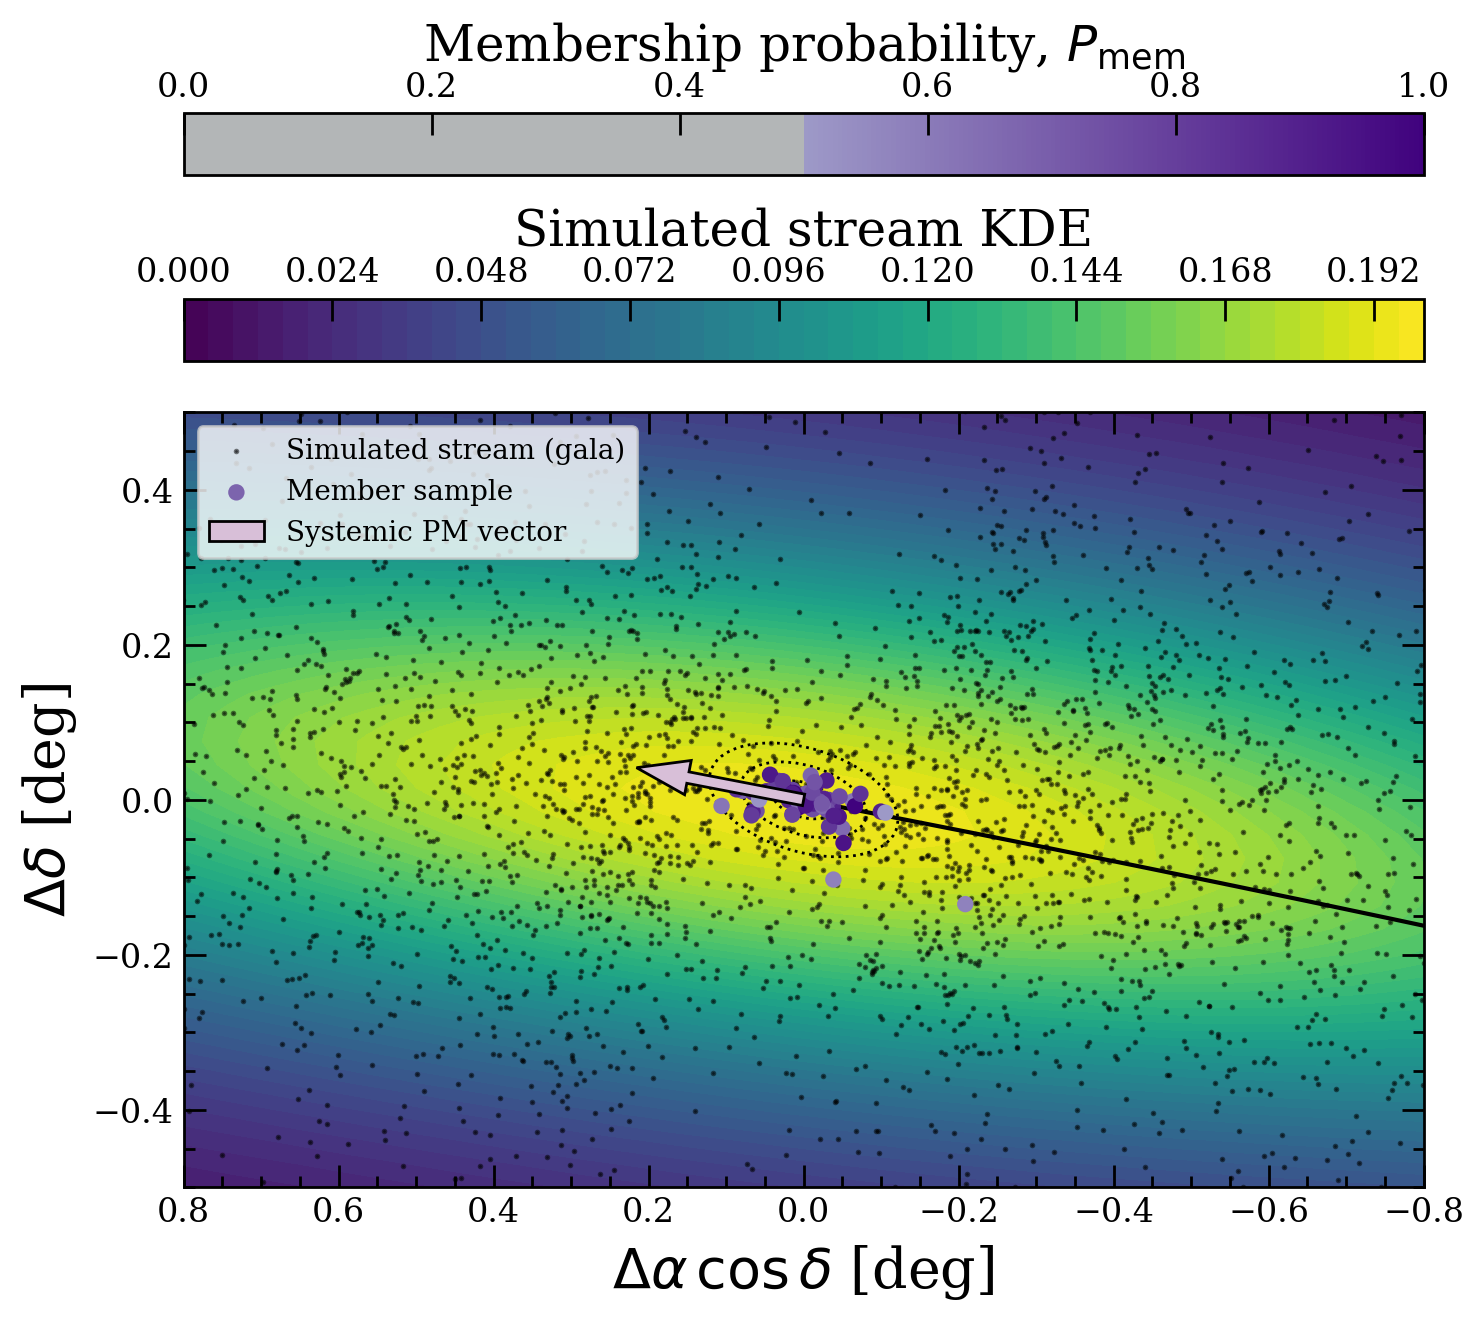

In [17]:
# particle spray stream plot
fig = plt.figure(figsize = (8, 8))
ax = fig.gca()
ax.set_aspect('equal', adjustable='box')

data1 = plt.contourf(X, Y, Z, levels=50, cmap='viridis', zorder = 0)

stream_ra = (wil1_stream_c2.ra.degree - ra_w1) * np.cos(np.deg2rad(dec_w1))
stream_dec = wil1_stream_c2.dec.degree - dec_w1
ax.scatter(stream_ra, stream_dec, marker='o', s=1, c='black', alpha = 0.5, zorder = 1, label = "Simulated stream (gala)")

# half-light radii
for ii in range(3):
    jj = 2 * (ii + 1)
    ellipse = Ellipse((0, 0), bax * jj, aax * jj, angle = 360-73, fill = False, linestyle = ":", edgecolor = "black", zorder = 1)
    ax.add_patch(ellipse)

ax.plot(orbit_ra, orbit_dec, c = "black", zorder = 1)

d = ax.scatter((w1_members["RA"] - ra_w1) * np.cos(np.deg2rad(dec_w1)), w1_members["DEC"] - dec_w1, 
           c = w1_members["prob_member"], cmap = new_purple_cmap, s = 24, vmin = 0, vmax = 1, zorder = 3, label = "Member sample")

plt.arrow(0, 0, pm_vec.pm_ra_cosdec.value / 5, pm_vec.pm_dec.value / 5, width = 0.015, facecolor = "thistle", 
          edgecolor = "black", zorder = 10, label = "Systemic PM vector")

ax.set_xlabel(r"$\Delta \alpha \, \cos \delta$ [deg]", labelpad = 5, size = 20).set_color('black')
ax.set_ylabel(r"$\Delta \delta$ [deg]", labelpad = 5, size = 20).set_color('black')

ax.set_xticks(np.arange(-0.8, 1, .2), minor = False)
ax.set_xticks(np.arange(-0.8, 1, 0.05), minor = True)
ax.tick_params(which = "major", axis = "x", direction = "in", size = 8, labelsize = 12, color = "black", top = True)
ax.tick_params(which = "minor", axis = "x", direction = "in", size = 4, color = "black", top = True)

ax.set_yticks(np.arange(-0.6, 0.6, 0.2), minor = False)
ax.set_yticks(np.arange(-0.6, 0.6, 0.05), minor = True)
ax.tick_params(which = "major", axis = "y", direction = "in", size = 8, labelsize = 12, color = "black", right = True)
ax.tick_params(which = "minor", axis = "y", direction = "in", size = 4, color = "black", right = True)

offset = 1.3
ax.set_xlim(0.8, -0.8)
ax.set_ylim(-0.5, 0.5)

cbar1 = plt.colorbar(d, fraction = 0.058, location = "top", pad=0.1)
cbar1.set_label(r"Membership probability, $P_{\rm mem}$", fontsize = 18)

cbar2 = plt.colorbar(data1, fraction = 0.06, location = "top")
cbar2.set_label("Simulated stream KDE", fontsize = 18)

ax.legend(loc = 'upper left', fontsize = 10, frameon = True)

fig.savefig("plots/8_stream.pdf", dpi = 600, transparent = True)